In [1]:
import numpy as np
import numpy.random as rnd
import scipy as sp
from scipy import optimize, stats
import matplotlib.pyplot as plt
import seaborn as sns

### Computing the Y∼(𝝻,𝞂) , N∼BN(n,p) parameters 

In [2]:
def p():
    return 120/13**2
def n():
    return 120*p() / (1-p())
def sigma():
    return (np.log(3500) - np.log(45)) / stats.norm.ppf(0.995) - stats.norm.ppf(0.5)
def mu():
    return (np.log(45)*stats.norm.ppf(0.995) - np.log(3500)*stats.norm.ppf(0.5)) / stats.norm.ppf(0.995) - stats.norm.ppf(0.5)

print("n:", n(),",", "p:", p())
print("𝝻:",mu(), ",", "𝞂:", sigma())

n: 293.87755102040813 , p: 0.7100591715976331
𝝻: 3.8066624897703196 , 𝞂: 1.6902734011561145


### Checking that the parameters are accurates

VaR_0.995(Y) =  3491.9735920445605 M(Y) =  44.96227824347144


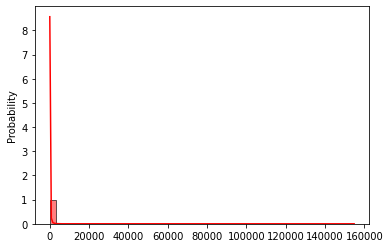

In [3]:
lognormal = rnd.lognormal(mu(),sigma(), 100000)
sns.histplot(data=lognormal, stat="probability",color="red", bins= 50, kde=True)
print("VaR_0.995(Y) = ", np.quantile(lognormal, 0.995), "M(Y) = ", np.quantile(lognormal, 0.5) )

E(N) =  120.04117 V(N) =  169.4927750311


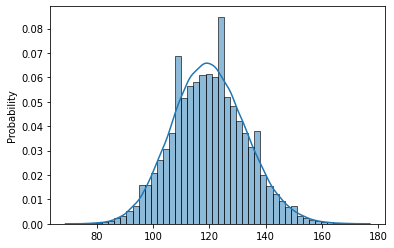

In [4]:
BinomialN = rnd.negative_binomial(n(), p(), 100000)
sns.histplot(data=BinomialN, stat="probability", bins=50, kde=True)
print("E(N) = ", np.mean(BinomialN), "V(N) = ", np.var(BinomialN) )

Once we  have these parameters, we can simulate de random variable S so that we can obtain the different quantiles we need 

In [5]:
def Simulaciones_S():
    S = np.zeros(100000)
    N = rnd.negative_binomial(n(),p())
    Y = np.zeros(0)
    R = range(0,100000)
    for i in R:
        Yi= rnd.lognormal(mu(),sigma(), N)
        S[i] = np.sum(Yi)
    return (S)

In [6]:
Simulaciones_S()

array([31843.10241424, 27281.68932072, 36692.97140192, ...,
       15844.55731066, 20147.69298987, 26745.00394338])

In [14]:
MS = np.quantile(np.log(Sim),0.50)
Q75S = np.quantile(np.log(Sim),0.75)
VaRS = np.quantile(np.log(Sim),0.995)
Sim = Simulaciones_S()

M(S)= 10.065417538546782
Q0.75(S)= 10.253077666687894
VaR_0.995(S)= 11.044800063974161


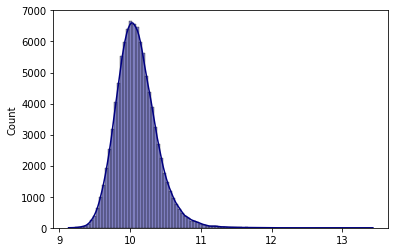

In [7]:
sns.histplot(data=np.log(Sim), bins=100, kde=True, color="navy")
print("M(S)=", MS)
print("Q0.75(S)=", Q75S) 
print("VaR_0.995(S)=", VaRS)

### For de hyperparameter 𝛍_0

In [8]:
mu_0 = np.mean(np.log(Sim))
print("E(S)=" , mu_0 )

E(S)= 10.089283396871862


### For the other hyperparameters, first we define:

Sabemos que *(prior information)* T = log(S) ∼ St(𝛍, 𝛌, α) con 


                    𝝻 = E(log(S)) = 9.884
                    𝛌 = (n_0 * α) / (n_0+1)*𝛽 
                    α = 2α
Además conocemos que

                        T = 𝝻 + ( X * (1 / sqrt(𝛌) )
donde:

                                X ∼ St(α)
                        
para encontrar los valores de n_0 , 𝛽 y α tenemos que resolver el siguiente sistema de ecuaciones:
                
                        F_T^{-1}(0.5) = 9.85935
                       F_T^{-1}(0.75) = 10.063
                       F_T^{-1}(0.995) = 10.95

Podemos utilizar la herramienta sp.optimize (creo) para encontrar el mínimo de los valores que resuelva:

  ( F_T^{-1}(0.5) - 9.85935 )**2 + (F_T^{-1}(0.75) - 10.063)**2 + (F_T^{-1}(0.995) - 10.95)**2 = 0
                

In [151]:
def qtT(x, mu_0, lamda, alpha):  
    return stats.t.ppf(x, alpha) / np.sqrt(lamda) + mu_0

def qtPrior(p, mu_0, n_0, alpha, beta):
    return qtT(p, mu_0, n_0*alpha/((n_0 + 1)*beta), 2*alpha)

In [167]:
def obj_fun(x):
    n_0 = x[0]
    alpha = x[1]
    beta = x[2]
    return (qtPrior(0.5, mu_0, n_0, alpha, beta) - MS)**2 + (qtPrior(0.75, mu_0, n_0, alpha, beta) - Q75S)**2 + (qtPrior(0.995, mu_0, n_0, alpha, beta) - VaRS)**2 
x_0 = [1,2,1]
result = sp.optimize.fmin(obj_fun, x_0 )

result

Optimization terminated successfully.
         Current function value: 0.000570
         Iterations: 111
         Function evaluations: 207


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


0.06388841225280889

In [168]:
n_0 = result[0]
alpha = result[1]
beta = result[2]

In [169]:
def rvT(n, mu_0, lamda, alpha):  
    return stats.t.rvs(alpha, size=n)*(1/ np.sqrt(lamda) ) + mu_0

def rvPrior(n, mu_0, n_0, alpha, beta):
    return rvT(n, mu_0, n_0*alpha/((n_0 + 1)*beta), 2*alpha)

<AxesSubplot:ylabel='Count'>

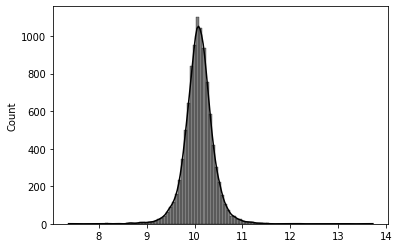

In [182]:
sns.histplot(data=rvPrior(10000,mu_0,n_0,alpha,beta) , bins=100 , kde=True, color='black')

In [184]:
own_obs = [4917, 32666, 12813, 17664, 23994]
mu_m = ( n_0*mu_0 + len(own_obs)*np.mean(own_obs) )/ (n_0 + len(own_obs))
mu_m

[4917, 32666, 12813, 17664, 23994]

14564.396413143904

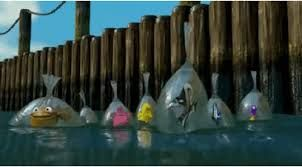